In [1]:
import pandas as pd
import math
import numpy as np
from collections import Counter
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
import re
import string
import networkx as nx
import community as community_louvain  # Install python-louvain package
from Seb_Folder.Louvain import NewsData, calculate_modularity
from networkx.algorithms.community import louvain_communities, modularity
from random import randint, seed

np.random.seed(42)
seed(42)

In [ ]:
stock_data = "Stock_prices_2021_to_2024.csv"
reddit_data = "Reddit_2021_to_2024.csv"
news_data = "combined_news_with_bodies.csv"

# Load the stock data
stock_df = pd.read_csv(stock_data)
# Load the reddit data
reddit_df = pd.read_csv(reddit_data)
# Load the news data
news_df = pd.read_csv(news_data)


# Add the title and body columns together
reddit_df['body'] = reddit_df['title'] + ' ' + reddit_df['body']
news_df['body'] = news_df['title'] + ' ' + news_df['body']
print("Added the df's together")

# Drop rows with NA values
reddit_df = reddit_df.dropna(subset=['body', 'title'])
news_df = news_df.dropna(subset=['body', 'title'])


reddit = NewsData(news_df)
print("Created the NewsData object")

# Step 1: Build LSH and find near-duplicates
reddit.build_lsh(threshold=0.95)  # High threshold to detect near-duplicates
print("Built the LSH")
duplicate_groups = reddit.find_duplicates()
print("Found duplicates")
    
# Step 2: Merge near-duplicates
reddit.merge_duplicates(duplicate_groups)
print("Merged duplicates")


Added the df's together
Created the NewsData object


Building LSH index: 100%|██████████| 50382/50382 [06:38<00:00, 126.27it/s]


Built the LSH
Found duplicates
Merged duplicates


In [ ]:
from tqdm import tqdm

# Create the graph
G = nx.Graph()
num_docs = reddit_df.shape[0]
total_comparisons = num_docs * (num_docs - 1) // 2

reddit.build_lsh(threshold=0.3, num_perm=2048)  # Lower threshold for general similarity

# Add edges to the graph based on similarity scores
for i, j in tqdm(reddit.compute_similarity_lsh(), total=total_comparisons, desc="Building Graph"):
    G.add_edge(i, j)

# Perform Louvain community detection
partition = louvain_communities(G, resolution=1)    

# Print the community detection results
print("\nLouvain Community Detection Result:")
print(partition)

print("\nModularity:", modularity(G, partition))


Building Graph:  43%|████▎     | 16612240/38206911 [07:06<09:14, 38942.65it/s]


KeyboardInterrupt: 

In [14]:
# Remove communities consisting of under 4 nodes
print("\nNumber of Communities:", len(partition))

# Make a list of distinct colors for the communities
colors = ["#"+''.join([randint(0, 255).to_bytes(1, 'big').hex() for _ in range(3)]) for _ in range(len(partition))]



Number of Communities: 245


In [19]:
# Assign nodes to their corresponding communities
import netwulf as nw
import matplotlib.pyplot as plt

node_to_community = {}
for community_index, community in enumerate(partition):
    for node in community:
        node_to_community[node] = community_index

# Add the community data to each node as an attribute
for node in G.nodes():
    G.nodes[node]['group'] = node_to_community[node]
    G.nodes[node]['color'] = colors[node_to_community[node]]

graph_to_plot = G.copy()
# REMOVE NODES WITH COMMUNITY SIZE LESS THAN 4 (for plotting purposes)
for community_index, community in enumerate(partition):
    if len(community) < 4:
        for node in community:
            graph_to_plot.remove_node(node)

print("Number of nodes:", G.nodes(data=True))

nw.visualize(graph_to_plot, config={'zoom': 0.1, 'linkAlpha':0.1, 'collisions': False})

Number of nodes: [(0, {'group': 33, 'color': '#7363e8'}), (2848, {'group': 33, 'color': '#7363e8'}), (5027, {'group': 64, 'color': '#a6b984'}), (3820, {'group': 33, 'color': '#7363e8'}), (595, {'group': 64, 'color': '#a6b984'}), (3967, {'group': 64, 'color': '#a6b984'}), (1, {'group': 0, 'color': '#f6c3b3'}), (532, {'group': 0, 'color': '#f6c3b3'}), (1174, {'group': 0, 'color': '#f6c3b3'}), (2, {'group': 33, 'color': '#7363e8'}), (2855, {'group': 33, 'color': '#7363e8'}), (1037, {'group': 64, 'color': '#a6b984'}), (4208, {'group': 64, 'color': '#a6b984'}), (1843, {'group': 33, 'color': '#7363e8'}), (4727, {'group': 33, 'color': '#7363e8'}), (2397, {'group': 33, 'color': '#7363e8'}), (5, {'group': 64, 'color': '#a6b984'}), (4985, {'group': 64, 'color': '#a6b984'}), (1475, {'group': 64, 'color': '#a6b984'}), (959, {'group': 64, 'color': '#a6b984'}), (7, {'group': 100, 'color': '#cb2a35'}), (5533, {'group': 100, 'color': '#cb2a35'}), (14, {'group': 30, 'color': '#cf6607'}), (1474, {'group

(None, None)

In [20]:
aggregate_graph = nx.Graph()

for node in G.nodes(data=True):
    comm_node = node[1]['group']
    if comm_node not in aggregate_graph.nodes:
        aggregate_graph.add_node(comm_node, radius=1, group=comm_node)
        aggregate_graph.nodes[comm_node]['color'] = colors[comm_node]
    else:
        aggregate_graph.nodes[comm_node]['radius'] += 1

for n1, n2, data in G.edges(data=True):
    comm1 = G.nodes[n1]['group']
    comm2 = G.nodes[n2]['group']
    # If the edge exists in the original graph, add it to the aggregate graph
    if not aggregate_graph.has_edge(comm1, comm2):
        aggregate_graph.add_edge(comm1, comm2, weight=1)
    else:   
        aggregate_graph[comm1][comm2]['weight'] += 1

print("Edges: ", aggregate_graph.edges(data=True))
print("Nodes: ", aggregate_graph.nodes(data=True))

nw.visualize(aggregate_graph, config={'zoom': 0.1, 'link_alpha':0.5, 'collisions': False, 'scale_node_size_by_strength': True, 'display_singleton_nodes': False,
                                      'link_width': 15, 'link_width_variation': 0.6})
    

Edges:  [(33, 33, {'weight': 58}), (33, 64, {'weight': 34}), (33, 46, {'weight': 1}), (33, 26, {'weight': 1}), (64, 64, {'weight': 1264}), (64, 46, {'weight': 24}), (64, 30, {'weight': 15}), (64, 26, {'weight': 52}), (64, 81, {'weight': 20}), (64, 51, {'weight': 15}), (64, 87, {'weight': 1}), (64, 100, {'weight': 1}), (64, 50, {'weight': 4}), (64, 92, {'weight': 1}), (64, 232, {'weight': 1}), (64, 127, {'weight': 1}), (0, 0, {'weight': 11}), (100, 100, {'weight': 109}), (100, 21, {'weight': 3}), (100, 202, {'weight': 1}), (30, 30, {'weight': 47}), (30, 81, {'weight': 1}), (30, 50, {'weight': 2}), (30, 51, {'weight': 1}), (123, 123, {'weight': 65}), (26, 26, {'weight': 132}), (26, 81, {'weight': 1}), (26, 21, {'weight': 1}), (26, 46, {'weight': 2}), (1, 1, {'weight': 3}), (81, 81, {'weight': 75}), (81, 51, {'weight': 1}), (81, 46, {'weight': 2}), (76, 76, {'weight': 58}), (76, 51, {'weight': 1}), (138, 138, {'weight': 31}), (2, 2, {'weight': 1}), (3, 3, {'weight': 1}), (4, 4, {'weight':

(None, None)

Community 1 Size: 509


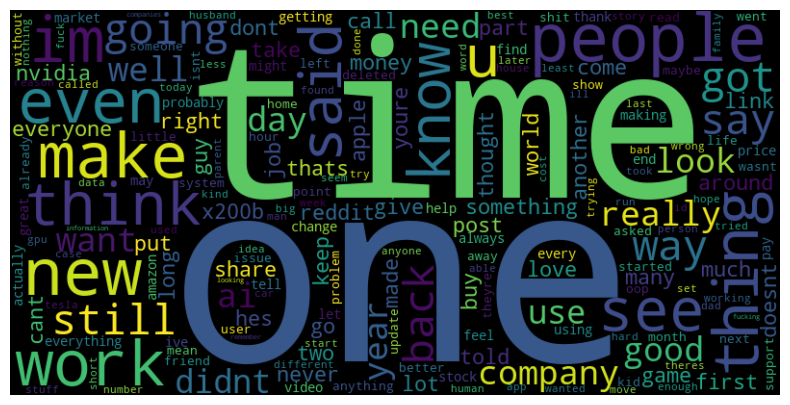

Community 2 Size: 101


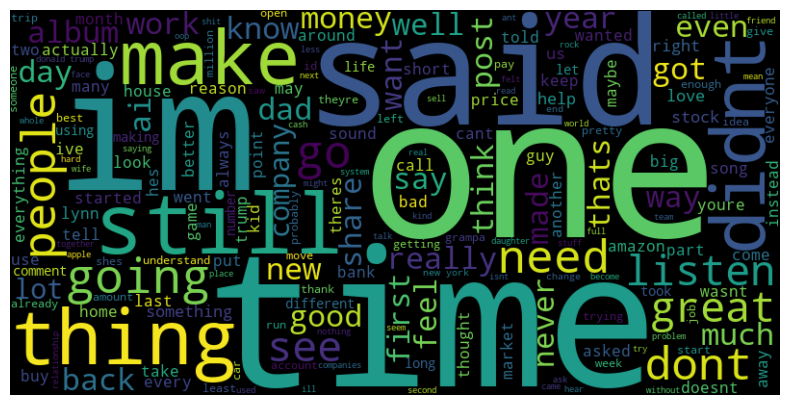

Community 3 Size: 93


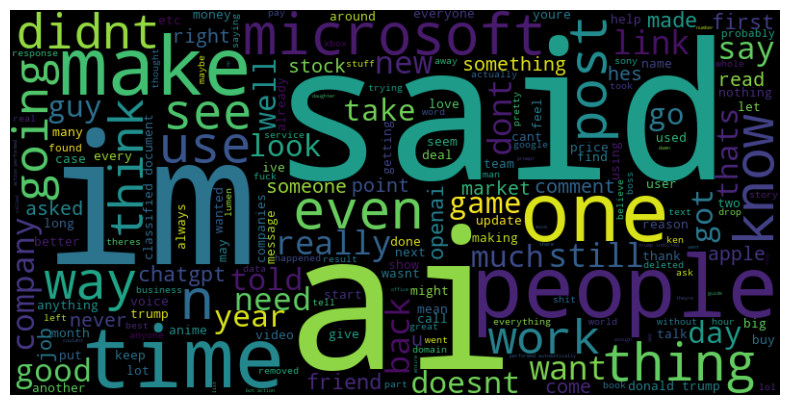

Community 4 Size: 86


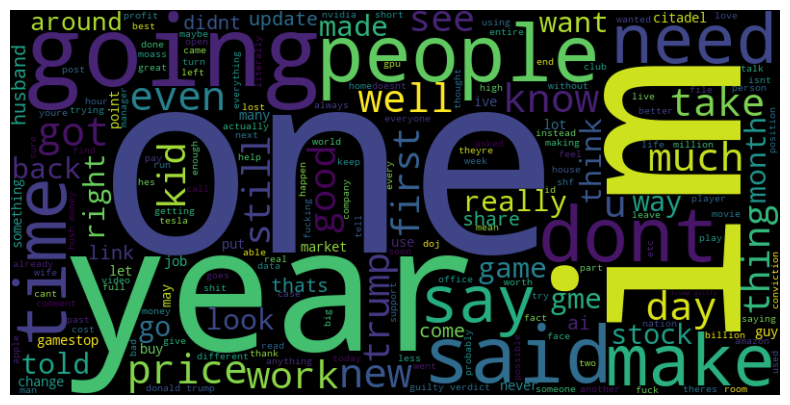

Community 5 Size: 82


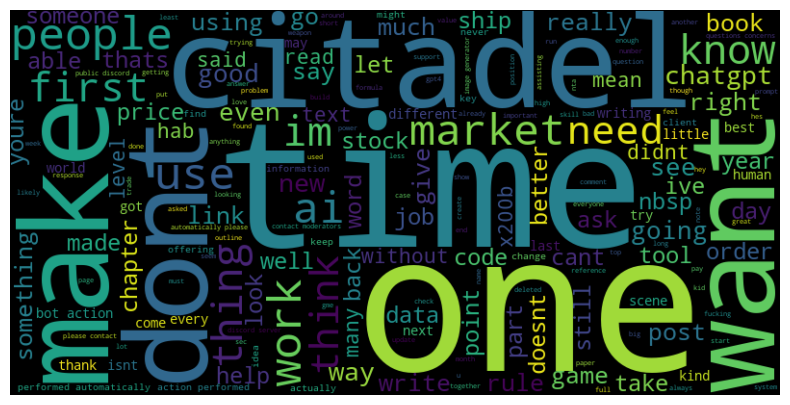

Community 6 Size: 82


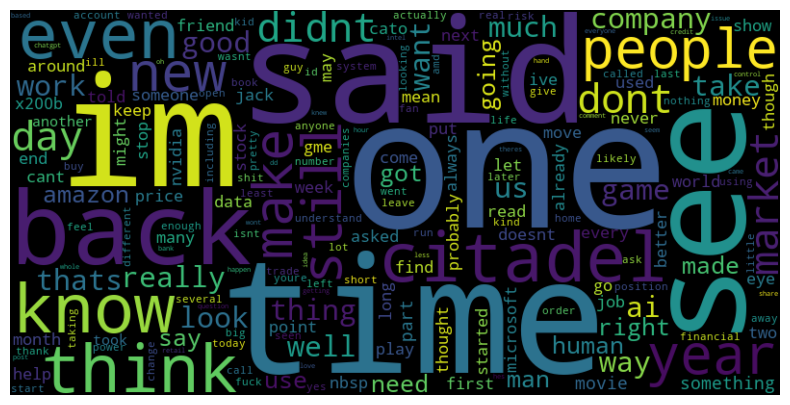

Community 7 Size: 53


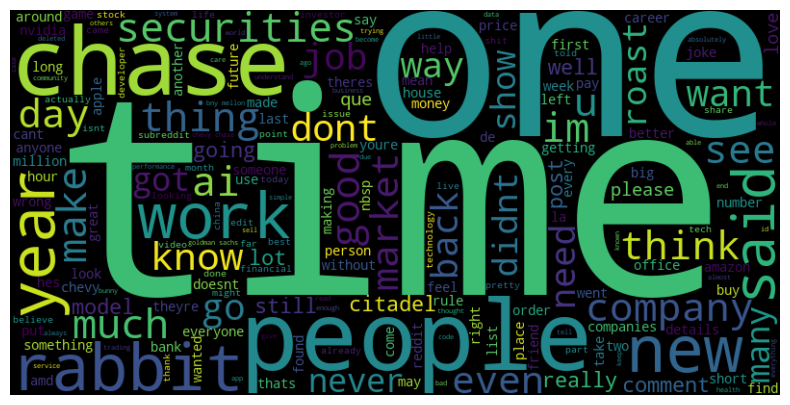

Community 8 Size: 45


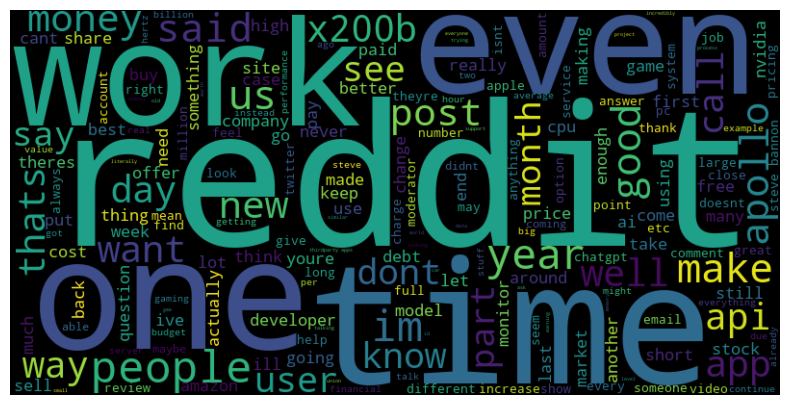

Community 9 Size: 42


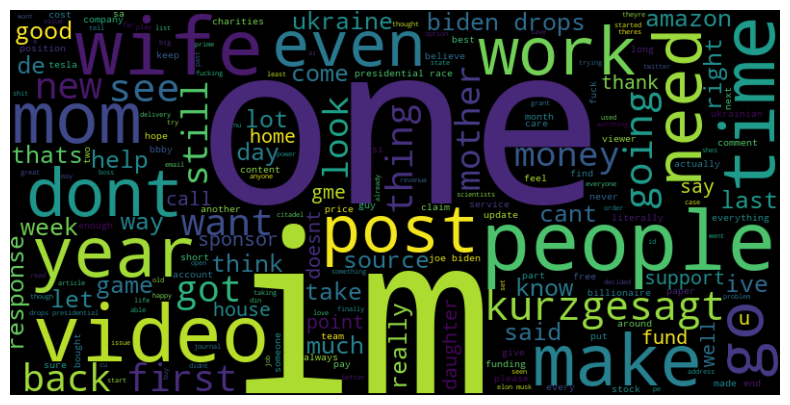

Community 10 Size: 34


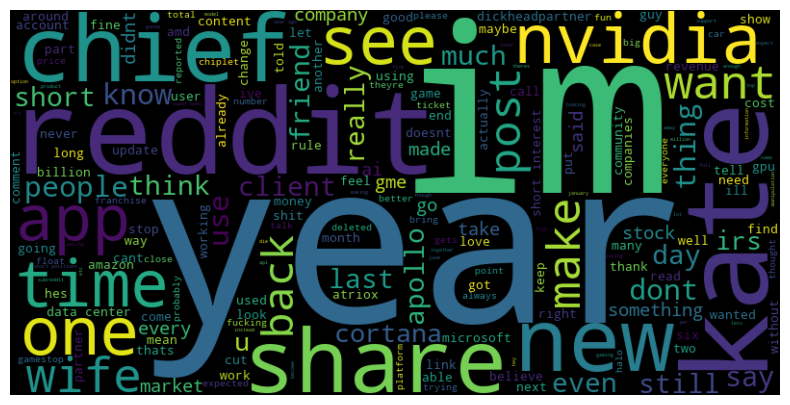

Community 11 Size: 33


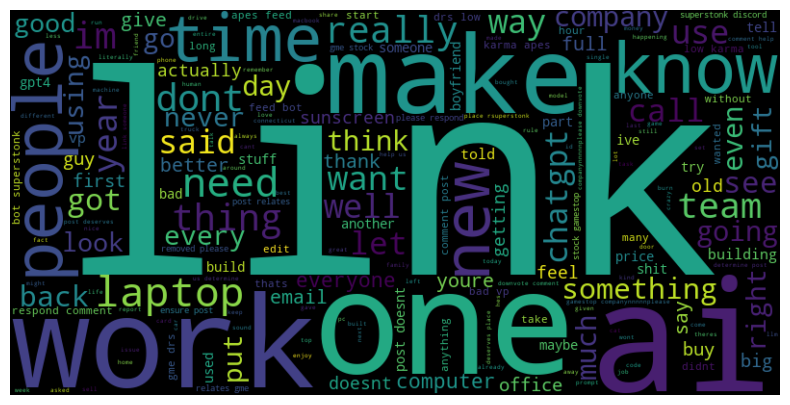

Community 12 Size: 33


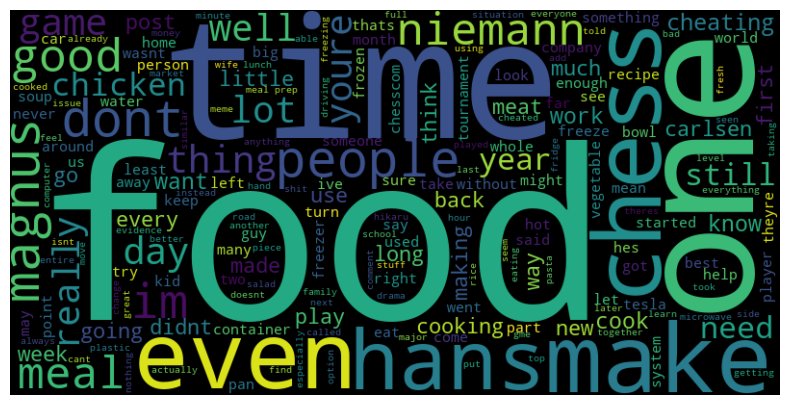

Community 13 Size: 31


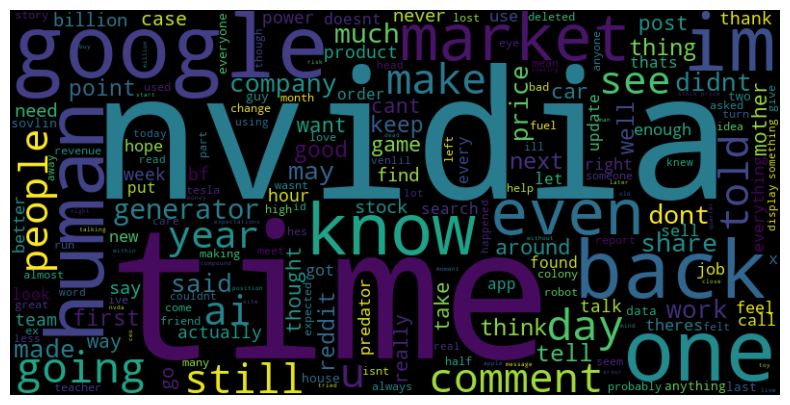

Community 14 Size: 22


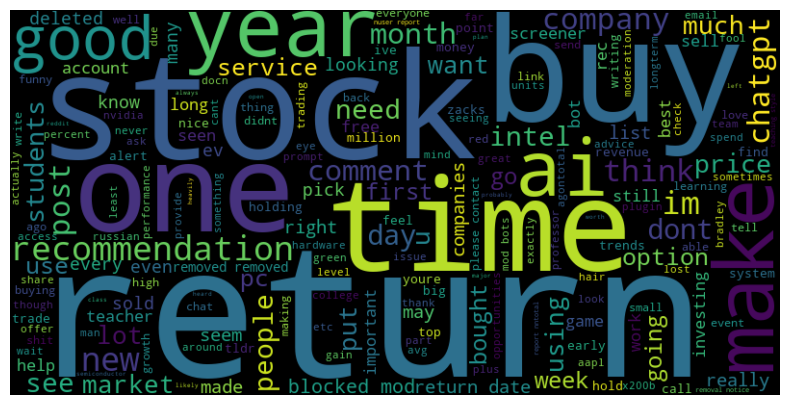

Community 15 Size: 19


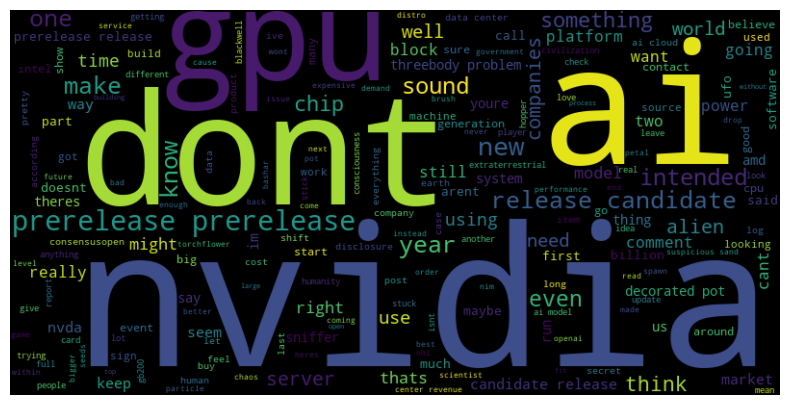

Community 16 Size: 18


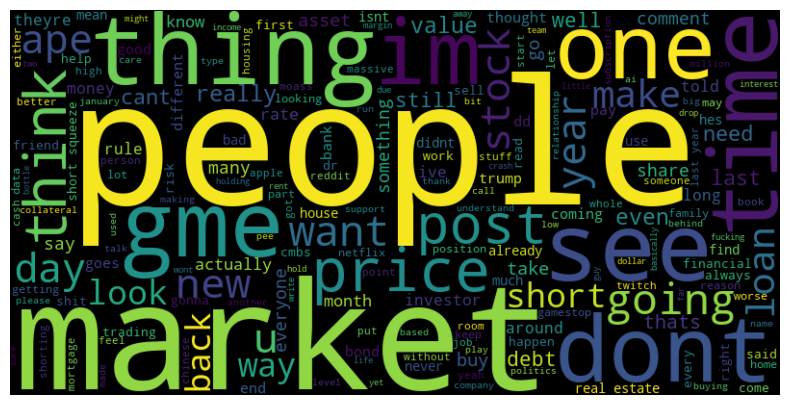

Community 17 Size: 16


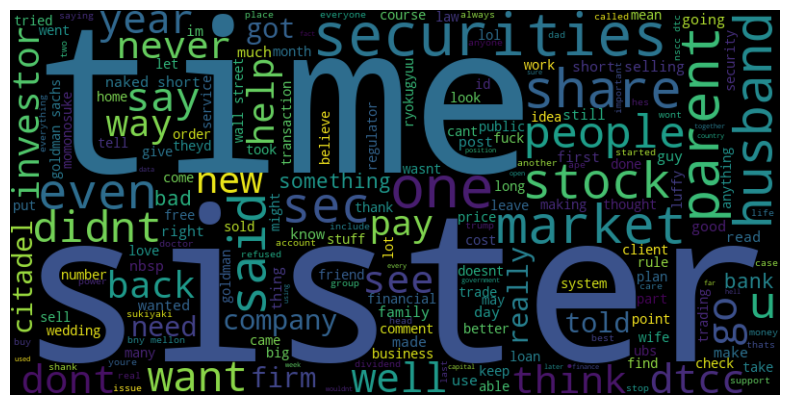

Community 18 Size: 15


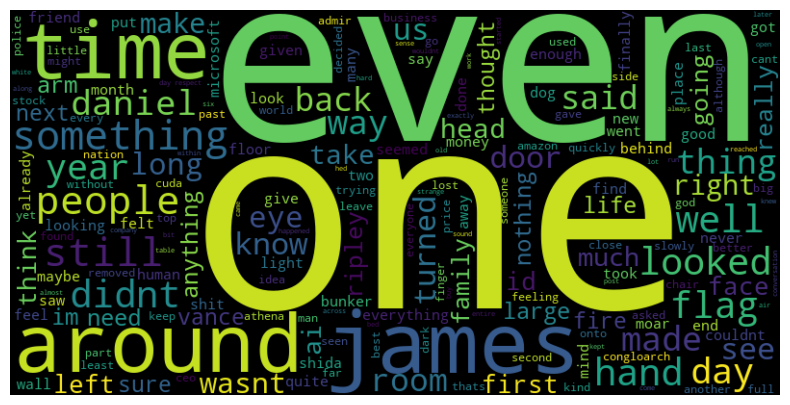

Community 19 Size: 10


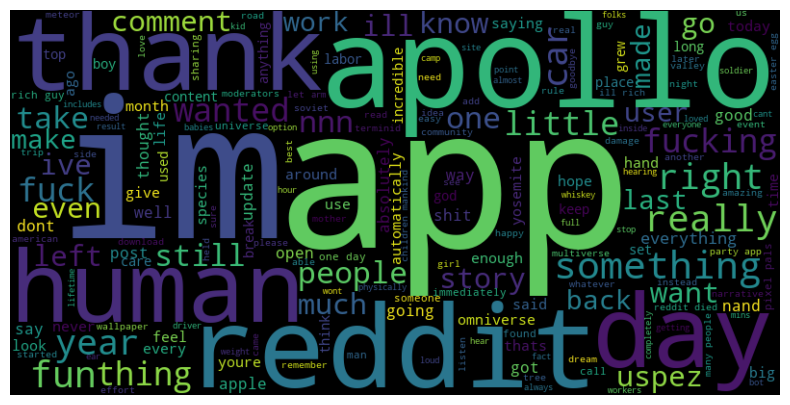

Community 20 Size: 8


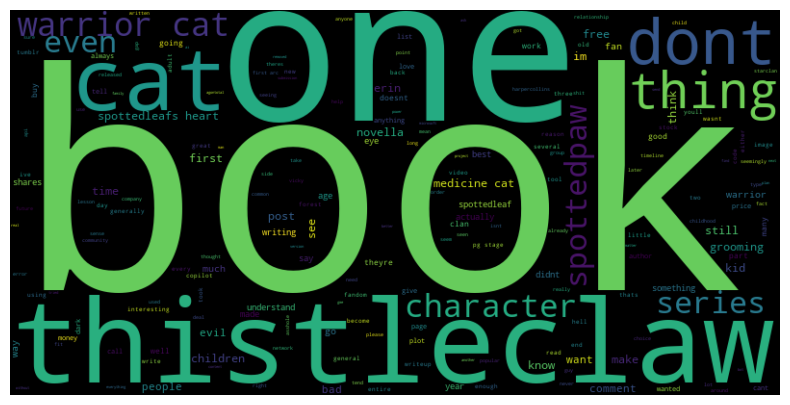

In [26]:
# Plot the word clouds for each of the 10 largest communities
from wordcloud import WordCloud

# Sort the communities by size
sorted_partition = sorted(partition, key=lambda x: len(x), reverse=True)

for i in range(20):
    community = sorted_partition[i]
    print("Community", i+1, "Size:", len(community))
    # Combine the text of all the documents in the community
    text = " ".join(reddit_df.iloc[node]['cleaned'] for node in community)
    wordcloud = WordCloud(width=800, height=400).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
